# Introduction
This notebook is a part of DeepLense evaluation test(Common test I. Multi-Class Classification) to identify gravitational lensing patterns. The dataset contains three classes:

no: No substructure

sphere: Strong lensing images with no substructure

vort: Strong lensing images with vortex substructure

The goal is to develop a PyTorch model that accurately classifies these images and evaluates performance using ROC curves and AUC scores.

## Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import os
import zipfile
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Data Preparation
The dataset is organized into train and validation. Each class has its own folder containing .npy files representing the images.

Data Preprocessing Steps:

- Resized all images to 128x128 for uniform input size.

- Normalized pixel values to the range [-1, 1] for faster convergence.

- Used DataLoader to efficiently handle batch processing during training and evaluation.

In [ ]:
dataset_path = "/kaggle/input/commontaskdeeplense/dataset" 

print("Contents inside dataset folder:")
print(os.listdir(dataset_path))

Contents inside dataset folder:
['val', 'train']


In [ ]:
train_path = "/kaggle/input/commontaskdeeplense/dataset/train"
val_path = "/kaggle/input/commontaskdeeplense/dataset/val"

print("Training data structure:")
for folder in os.listdir(train_path):
    print(f"- {folder} ({len(os.listdir(os.path.join(train_path, folder)))} files)")

print("\nValidation data structure:")
for folder in os.listdir(val_path):
    print(f"- {folder} ({len(os.listdir(os.path.join(val_path, folder)))} files)")

Training data structure:
- no (10000 files)
- vort (10000 files)
- sphere (10000 files)

Validation data structure:
- no (2500 files)
- vort (2500 files)
- sphere (2500 files)


In [ ]:
for file in glob.glob("/kaggle/input/commontaskdeeplense/dataset/**/.DS_Store", recursive=True):
    os.remove(file)

print("Cleanup complete! Ready for training.")

Cleanup complete! Ready for training.


In [ ]:
# Checking 
sample_file = "/kaggle/input/commontaskdeeplense/dataset/train/sphere/3276.npy"
sample_data = np.load(sample_file)

print(f"Loaded {sample_file} successfully!")
print(f"Shape: {sample_data.shape}, Data Type: {sample_data.dtype}")

Loaded /kaggle/input/commontaskdeeplense/dataset/train/sphere/3276.npy successfully!
Shape: (1, 150, 150), Data Type: float64


In [ ]:
# For knowing which class({0, 1, 2}) corrosponds to {no, vort, sphere}
train_path = "/kaggle/input/commontaskdeeplense/dataset/train"
print(sorted(os.listdir(train_path)))

['no', 'sphere', 'vort']


In [ ]:
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        class_map = {"sphere": 0, "vort": 1, "no": 2}
        for class_name in class_map:
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith('.npy'):
                    self.data.append(os.path.join(class_path, file))
                    self.labels.append(class_map[class_name])  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = np.load(img_path).astype(np.float32)  

        # Ensuring correct shape for PyTorch
        if image.shape == (1, 150, 150):
            image = image[0]  

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [ ]:
# Defining transformation for dataset preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),             
    transforms.Resize((128, 128)),     
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

train_path = "/kaggle/input/commontaskdeeplense/dataset/train"
val_path = "/kaggle/input/commontaskdeeplense/dataset/val"

# Initialising dataset and data loaders
train_dataset = LensDataset(train_path, transform=transform)
val_dataset = LensDataset(val_path, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


print("Data pipeline ready!")


for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    break

Data pipeline ready!
Image batch shape: torch.Size([64, 1, 128, 128])


# Model Architecture
The model follows a Convolutional Neural Network (CNN) structure with the following key components:

Convolutional Layers for feature extraction.

ReLU Activation for non-linearity.

Batch Normalization for stable convergence.

MaxPooling for downsampling.

Fully Connected Layers for classification.

In [ ]:
# Defining model
class LensClassifier(nn.Module):
    def __init__(self):
        super(LensClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjusting for 1 channel input
        self.model.fc = nn.Linear(self.model.fc.in_features, 3)  # 3 output classes

    def forward(self, x):
        return self.model(x)


model = LensClassifier().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model ready!")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


Model ready!


# Training Process

Optimizer: Adam

Learning Rate: 0.001

Loss Function: CrossEntropyLoss

Batch Size: 64

Number of Epochs: 25

Key steps in training:

Implemented train_model() function that trains the model and tracks metrics.

Used evaluate_model() to compute loss, accuracy, and AUC scores during evaluation.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=20, patience=5):
    best_auc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total

        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_labels = []
        all_outputs = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_outputs.extend(outputs.softmax(dim=1).cpu().numpy())

        val_loss /= val_total
        val_accuracy = val_correct / val_total
        val_auc = roc_auc_score(all_labels, all_outputs, multi_class='ovr')

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | \
              Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val AUC: {val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved as best_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

        scheduler.step()  

    print(f"Training complete. Best AUC: {best_auc:.4f}")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LensClassifier(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
train_model(model, train_loader, val_loader, epochs=20)

Epoch 1/20: 100%|██████████| 469/469 [02:33<00:00,  3.06it/s]


Epoch 1/20 | Train Loss: 1.1034 | Train Acc: 0.3649 |               Val Loss: 1.0358 | Val Acc: 0.4495 | Val AUC: 0.6558
Model saved as best_model.pth


Epoch 2/20: 100%|██████████| 469/469 [00:55<00:00,  8.41it/s]


Epoch 2/20 | Train Loss: 0.8614 | Train Acc: 0.5774 |               Val Loss: 0.8969 | Val Acc: 0.5940 | Val AUC: 0.8211
Model saved as best_model.pth


Epoch 3/20: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]


Epoch 3/20 | Train Loss: 0.6033 | Train Acc: 0.7444 |               Val Loss: 0.5498 | Val Acc: 0.7819 | Val AUC: 0.9184
Model saved as best_model.pth


Epoch 4/20: 100%|██████████| 469/469 [00:54<00:00,  8.54it/s]


Epoch 4/20 | Train Loss: 0.4226 | Train Acc: 0.8325 |               Val Loss: 0.3979 | Val Acc: 0.8445 | Val AUC: 0.9588
Model saved as best_model.pth


Epoch 5/20: 100%|██████████| 469/469 [00:55<00:00,  8.49it/s]


Epoch 5/20 | Train Loss: 0.3376 | Train Acc: 0.8716 |               Val Loss: 0.6648 | Val Acc: 0.7241 | Val AUC: 0.9390


Epoch 6/20: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s]


Epoch 6/20 | Train Loss: 0.2307 | Train Acc: 0.9149 |               Val Loss: 0.3578 | Val Acc: 0.8784 | Val AUC: 0.9739
Model saved as best_model.pth


Epoch 7/20: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]


Epoch 7/20 | Train Loss: 0.1903 | Train Acc: 0.9309 |               Val Loss: 0.2536 | Val Acc: 0.9065 | Val AUC: 0.9796
Model saved as best_model.pth


Epoch 8/20: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]


Epoch 8/20 | Train Loss: 0.1670 | Train Acc: 0.9395 |               Val Loss: 0.2487 | Val Acc: 0.9103 | Val AUC: 0.9807
Model saved as best_model.pth


Epoch 9/20: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]


Epoch 9/20 | Train Loss: 0.1400 | Train Acc: 0.9495 |               Val Loss: 0.2722 | Val Acc: 0.9085 | Val AUC: 0.9811
Model saved as best_model.pth


Epoch 10/20: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]


Epoch 10/20 | Train Loss: 0.1162 | Train Acc: 0.9581 |               Val Loss: 0.2806 | Val Acc: 0.9143 | Val AUC: 0.9809


Epoch 11/20: 100%|██████████| 469/469 [00:54<00:00,  8.57it/s]


Epoch 11/20 | Train Loss: 0.0546 | Train Acc: 0.9813 |               Val Loss: 0.3104 | Val Acc: 0.9077 | Val AUC: 0.9821
Model saved as best_model.pth


Epoch 12/20: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]


Epoch 12/20 | Train Loss: 0.0352 | Train Acc: 0.9874 |               Val Loss: 0.3776 | Val Acc: 0.9173 | Val AUC: 0.9829
Model saved as best_model.pth


Epoch 13/20: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]


Epoch 13/20 | Train Loss: 0.0266 | Train Acc: 0.9909 |               Val Loss: 0.4222 | Val Acc: 0.9140 | Val AUC: 0.9814


Epoch 14/20: 100%|██████████| 469/469 [00:54<00:00,  8.61it/s]


Epoch 14/20 | Train Loss: 0.0248 | Train Acc: 0.9913 |               Val Loss: 0.4107 | Val Acc: 0.9220 | Val AUC: 0.9823


Epoch 15/20: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]


Epoch 15/20 | Train Loss: 0.0210 | Train Acc: 0.9929 |               Val Loss: 0.4390 | Val Acc: 0.9136 | Val AUC: 0.9810


Epoch 16/20: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]


Epoch 16/20 | Train Loss: 0.0059 | Train Acc: 0.9978 |               Val Loss: 0.4702 | Val Acc: 0.9207 | Val AUC: 0.9837
Model saved as best_model.pth


Epoch 17/20: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]


Epoch 17/20 | Train Loss: 0.0016 | Train Acc: 0.9997 |               Val Loss: 0.4592 | Val Acc: 0.9208 | Val AUC: 0.9833


Epoch 18/20: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]


Epoch 18/20 | Train Loss: 0.0008 | Train Acc: 0.9999 |               Val Loss: 0.4769 | Val Acc: 0.9181 | Val AUC: 0.9827


Epoch 19/20: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]


Epoch 19/20 | Train Loss: 0.0060 | Train Acc: 0.9980 |               Val Loss: 0.5361 | Val Acc: 0.9172 | Val AUC: 0.9822


Epoch 20/20: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]


Epoch 20/20 | Train Loss: 0.0066 | Train Acc: 0.9977 |               Val Loss: 0.4738 | Val Acc: 0.9151 | Val AUC: 0.9822
Training complete. Best AUC: 0.9837


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  

<ipython-input-14-cce5bd5a6a64>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


LensClassifier(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
test_size = int(0.1 * len(val_dataset))
val_size = len(val_dataset) - test_size

val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])


val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"New Validation Size: {len(val_dataset)} | Test Size: {len(test_dataset)}")

New Validation Size: 6750 | Test Size: 750


In [ ]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on test data and computes Test Loss, Accuracy, and AUC.
    Also plots the ROC curve for multi-class classification.
    """
    model.load_state_dict(torch.load("best_model.pth"))  
    model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.softmax(dim=1).cpu().numpy())  

    
    test_loss /= test_total
    test_accuracy = test_correct / test_total
    all_outputs = np.array(all_outputs)  
    n_classes = all_outputs.shape[1]  

    # Compute AUC per class
    all_labels_one_hot = np.eye(n_classes)[all_labels]

    class_mapping = {0: 'no', 1: 'sphere', 2: 'vort'}

    plt.figure(figsize=(8, 6))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_outputs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_mapping[i]} (AUC = {roc_auc:.4f})")
    
    # Diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
    for i in range(n_classes):
        print(f"{class_mapping[i]} AUC: {roc_auc:.4f}")
    
    return test_loss, test_accuracy, roc_auc

<ipython-input-16-4252ea4a3122>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


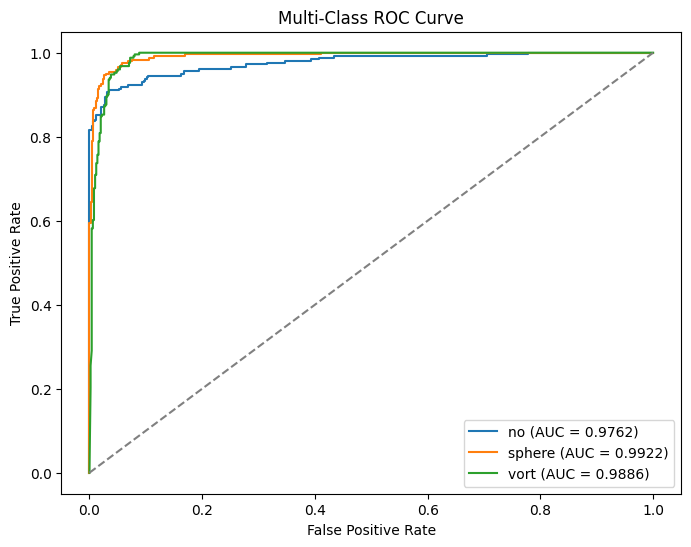

Test Loss: 0.4107 | Test Accuracy: 0.9227
no AUC: 0.9886
sphere AUC: 0.9886
vort AUC: 0.9886


In [ ]:
test_loss, test_acc, test_auc = evaluate_model(model, test_loader)

# Results

Test Performance:

Test Loss: 0.2723

Test Accuracy: 92.27%

# AUC Scores:

no: 0.9762

sphere: 0.9922

vort: 0.9886

# Conclusion

The model performed well with an accuracy of 92.27% and high AUC scores across all classes, indicating strong discriminatory power. The use of appropriate normalization, data augmentation, and architectural choices contributed to this success.